### Regresión múltiple
### Estimar el consumo de un vehículo a partir del resto de las variables

Para estimar el consumo de los vehículos se utilizará la regresión lineal, este tipo de modelos busca relacionar el valor que toma la variable independiente en función del resto de las variables. Esta relación es determinada por los parámetros del modelo.

En _scikit-learn_ los modelos de regresión lineal se implementa con la clase _LinearRegression_.

#### 1) Carga de datos y librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

auto=pd.read_csv('auto.csv',sep=',')

# separación de la variable independiente y dependiente
target='mpg'
features=list(auto.columns)
features.remove('mpg')

x=auto[features]
y=auto[target]


#x=pd.concat([x,pd.get_dummies(auto['origin'])],axis=1)
#x.columns=['cylinders', 'displacement','horsepower','weight','acceleration',
#         'model_year','origin1','origin2','origin3']
#print(x)

In [4]:
x.dtypes

cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
dtype: object

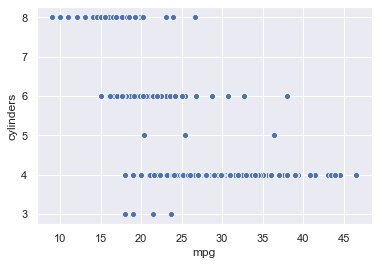

In [429]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x="mpg", y="cylinders", data=auto)

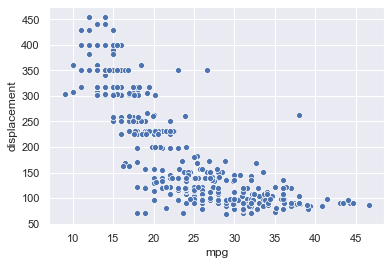

In [430]:
sns.scatterplot(x="mpg", y="displacement", data=auto)

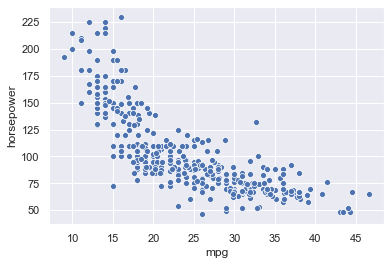

In [431]:
sns.scatterplot(x="mpg", y="horsepower", data=auto)

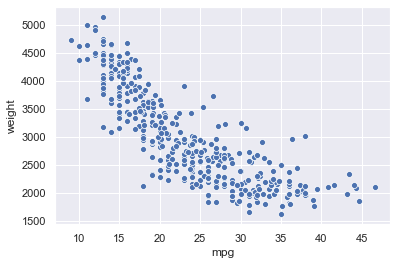

In [432]:
sns.scatterplot(x="mpg", y="weight", data=auto)

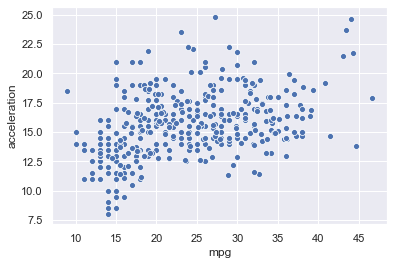

In [433]:
sns.scatterplot(x="mpg", y="acceleration", data=auto)

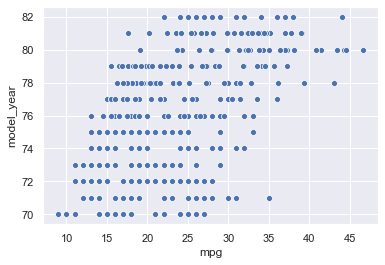

In [434]:
sns.scatterplot(x="mpg", y="model_year", data=auto)

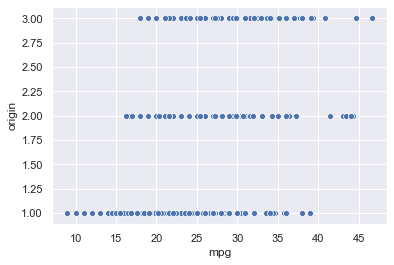

In [435]:
sns.scatterplot(x="mpg", y="origin", data=auto)

#### 2) Multicolinealidad

La existencia de multicolinealidad en el conjunto de variables independientes afecta de forma negativa al modelo que se construya. Cuando existe multicolinealidad significa que una variable puede ser calculada como combinación lineal de otras, por lo que en el proceso de entrenamiento se estará utilizando información duplicada.  
Una solución a este problema es utilizar el Factor de Inflación de la Varianza (VIF), este factor devuelve un valor para cada variable que cuanto más alto es, mayor multicolinealidad indica. Entonces esto significa que esa variable está explicada por otras y por lo tanto podría descartarse.

In [436]:
def calculateVIF(auto):
    features = list(auto.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = auto[x_features]
        y = auto[y_featue]
        
        model.fit(auto[x_features], auto[y_featue])
        
        result[y_featue] = 1/(1 - model.score(auto[x_features], auto[y_featue]))
    
    return result

In [437]:
calculateVIF(x.copy(deep = True))


,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
VIF,10.737535,21.836792,9.943693,10.83126,2.625806,1.244952,1.772386


La variable _displacement_ tiene un VIF de casi 22, seguido luego por _weight_ , _cylinders_ y _horsepower_ . Es posible que la variable displacement sea una combinación lineal de otras, por lo tanto se procede a eliminarla y volver a calcular los VIF. Puede suceder que al excluirla desciendan los valores de las otras dos caracterísitcas que tenían una alta multicolinealidad.



In [438]:
def selectDataUsingVIF(auto, max_VIF = 15):
    result = auto.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

calculateVIF(selectDataUsingVIF(x))

C:\Users\letos\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\letos\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\letos\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,cylinders,horsepower,weight,acceleration,model_year,origin
VIF,6.008253,9.088413,9.219674,2.598356,1.239409,1.59422


Al excluir _displacement_ descienden los valores de _weight_ , _cylinders_ y _horsepower_ . Aunque algunos valores siguen siendo altos se decide no excluirlos.

In [439]:
# Exclusión de la variable displacement	
target='mpg'
features=list(auto.columns)
features.remove('mpg')
features.remove('displacement')

x=auto[features]
y=auto[target]


#### 3)Creación del modelo

En primera instancia se ajusta un modelo con todas las variables separando los datos en dos dataset, uno para test y otro para entrenamiento. El dataset test sirve para comprobar que no haya sobreajuste en el modelo.
Como una de las variables es categórica entonces se convierte en una variable dummy para poder realizar el modelo.

In [440]:
# variable origin a dummy
features=list(auto.columns)
features.remove('origin')
features.remove('mpg')

x=auto[features]
x=pd.concat([x,pd.get_dummies(auto['origin'])],axis=1)
x.columns=['cylinders', 'displacement','horsepower','weight','acceleration',
        'model_year','origin1','origin2','origin3']
print(x)

     cylinders  displacement  horsepower  weight  acceleration  model_year  \
0            8         307.0       130.0  3504.0          12.0          70   
1            8         350.0       165.0  3693.0          11.5          70   
2            8         318.0       150.0  3436.0          11.0          70   
3            8         304.0       150.0  3433.0          12.0          70   
4            8         302.0       140.0  3449.0          10.5          70   
5            8         429.0       198.0  4341.0          10.0          70   
6            8         454.0       220.0  4354.0           9.0          70   
7            8         440.0       215.0  4312.0           8.5          70   
8            8         455.0       225.0  4425.0          10.0          70   
9            8         390.0       190.0  3850.0           8.5          70   
10           8         383.0       170.0  3563.0          10.0          70   
11           8         340.0       160.0  3609.0           8.0  

In [441]:
# separación del los datos en entrenamiento y test
x_train,x_test,y_train,y_test=train_test_split(x,y)

#Creación del modelo
model=LinearRegression()
model.fit(x_train,y_train)

#Predicciones
predict_train=model.predict(x_train)
predict_test=model.predict(x_test)

#Evaluación R2
print ('R2 en entrenamiento es: ', model.score(x_train,y_train))
print ('R2 en test es: ', model.score(x_test,y_test))
print ('Error cuadrático medio: %.4f' % mean_squared_error(y_train, predict_train))


R2 en entrenamiento es:  0.8412942738054272
R2 en test es:  0.7558004380759245
Error cuadrático medio: 9.5920


Al ejecutar el modelo de regresión, teniendo en cuenta todas la variables (luego de excluir displacement), obtenemos un R2 de 0,841 y un error cuadrático medio de 9,59. 

#### 3) Selección del mejor modelo - Lasso Regression  
 
Existen diversas metodologías para seleccionar los modelos, como por ejemplo **Stpewise** , el cual parte de un modelo con una cantidad de características y se prueba a agregar una a una el resto de características o a eliminar una a una las utilizadas. Una vez hecho esto, se comprueba la calidad de los modelos y se selecciona el mejor. Actualmente, a pesar de ser un método bastante popular en algunos entornos, no está imprentando en scikit-learn. Sinembargo, puede implementarse mediante un algoritmo.

Se decide que para seleccionar el mejor modelo se utilizará la regresión **Lasso** . Esta función indica el error cometido por el modelo en función de los parámetros, utilizando el algoritmo del gradiente descendente.  
Las funciones de esfuerzo se pueden modificar mediante la regularización. La regularización consiste en añadir una penalización a los coeficientes de regresión que sean demasiado grandes para reducir el sobreajuste. Se utilizará el método LASSO (least absolute shrinkage and selection operator), en el que la penalización consiste en añadir el parámetro del modelo multiplicado por una constante.
Al penalizar los parámetros que requieren mayor peso, permite seleccionar las características eliminado aquellas que necesitan valores de los parámetros más grandes para poder aportar información al modelo.  
La correcta determinación del valor del parámetro de regularización es clave para la obtención de modelos con una buena capacidad predictiva y que, a su vez, no presenten sobreajuste.
Para solucionar este problema existe GridSearchCV, con el cual se pueden crear modelos para la selección de parámetros. En este caso se utilizará para determinar el valor de alpha en la regresión LASSO.

In [442]:
from sklearn.linear_model import Lasso

model_ridge = Lasso(alpha = 0.1)
model_ridge.fit(x, y)

print(model_ridge.coef_)

[-0.06660805  0.0126583  -0.01331772 -0.00673194  0.05328912  0.76251936
 -1.8486989   0.          0.        ]


Elección del valor alpha para la regression Lasso


In [444]:
#############################################

from sklearn.model_selection import GridSearchCV

# Listado de alphas para ser evaluados
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001])

# Creación del modelo
model = Lasso()

# Selección del modelo
grid = GridSearchCV(estimator = model,
                    param_grid = dict(alpha = alphas),
                    cv = 10)
grid.fit(x, y)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

El mejor parametro es {'alpha': 0.0001}
El mejor score es 0.645530249916077


C:\Users\letos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [445]:
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(alpha = sp_rand())

rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 100,
                             cv = 10,
                             random_state = 1)
rsearch.fit(x, y)

# Los mejores parametros para el modelo
print('El mejor parametro es', rsearch.best_params_)
print('El mejor score es', rsearch.best_score_)

El mejor parametro es {'alpha': 0.00011437481734488664}
El mejor score es 0.6455299084282562


C:\Users\letos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


El mejor alpha es 0.00011437481734488664, con este valor se procede a estimar el modelo Lasso

In [447]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha = 0.00011437481734488664)
model_lasso.fit(x, y)

#Evaluación R2
print ('El R2 del modelo Lasso es: ', model_lasso.score(x,y))

df = pd.DataFrame(list(model_lasso.coef_), index =x.columns, 
                                              columns =['Coeficientes']) 
print(df)

El R2 del modelo Lasso es:  0.824199466368569
              Coeficientes
cylinders        -0.489216
displacement      0.023966
horsepower       -0.018177
weight           -0.006710
acceleration      0.079073
model_year        0.777017
origin1          -2.629312
origin2           0.000000
origin3           0.222582


Al ejecutar el modelo Lasso se observa que el coeficiente de la variable origin3 es nulo, es de esperar que fuera así dado que es parte de una variable categórica. El parámetro de regularización determina la cantidad de características que serán utilizadas en el modelo, que en este caso son 8.  
  
  
|Variables|Coeficientes|
|-----------|-------|
|cylinders    |    -0.489216|
|displacement |    0.023966|
|horsepower   |    -0.018177|
|weight       |    -0.006710|
|acceleration |     0.079073|
|model_year   |     0.777017|
|origin1      |    -2.629312|
|origin3      |     0.222582|

  